# VSC result analysis

In [1]:
import glob
import os
import sys
import itertools
import collections
from typing import List

import pandas as pd
import numpy as np
import tqdm  #.notebook as tqdm
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
sys.path.append("..")

In [3]:
from vsc.metrics import (
    Match as Match1, match_metric, CandidatePair, average_precision,
    MatchingTrackMetrics, format_video_id, Dataset,
)

In [4]:
class Match(Match1):

    @classmethod
    def from_df(
        cls, df, is_gt=False, check=True
    ) -> List["Match"]:
        df = df.copy()
        df["query_id"] = df.query_id.map(lambda x: format_video_id(x, Dataset.QUERIES))
        df["ref_id"] = df.ref_id.map(lambda x: format_video_id(x, Dataset.REFS))
        if is_gt:
            df["score"] = 1.0
        df = df[list(cls._fields)]
        if check:
            for field in cls._fields:
                assert not df[field].isna().any()
        return [Match(**record) for record in df.to_dict("records")]

In [79]:
DATA_PATH = "../data"
OUTPUT_PATH = f"{DATA_PATH}/plots"

In [80]:
if os.path.exists(DATA_PATH):
    os.makedirs(OUTPUT_PATH)

## Read ground truth with transform data

In [6]:
gt_df = pd.read_csv(f"{DATA_PATH}/vsc_test_gt_xforms.csv")
gt_df["transforms"] = gt_df.transform_name.map(lambda x: x.replace("_", " ").split("  "))
# del gt_df["transform_name"]

In [7]:
gt_df

,query_id,ref_id,transform_name,query_start,query_end,ref_start,ref_end,transforms
0,Q301382,R232095,time_crop__insert_in_background__grayscale__ch...,13.121373,18.564270,4.309982,10.125000,"[time crop, insert in background, grayscale, c..."
1,Q306255,R231984,time_decimate__insert_in_background__overlay_e...,57.918575,65.888710,16.253643,24.261105,"[time decimate, insert in background, overlay ..."
2,Q301064,R232027,insert_in_background_multiple__change_video_sp...,0.108141,10.417902,1.210376,12.373480,"[insert in background multiple, change video s..."
3,Q307074,R221528,insert_in_background_multiple__change_video_sp...,2.376142,12.172334,9.549600,21.892908,"[insert in background multiple, change video s..."
4,Q304840,R221400,time_crop__insert_in_background__hflip__encodi...,14.419863,24.353024,33.909800,39.873707,"[time crop, insert in background, hflip, encod..."
...,...,...,...,...,...,...,...,...
2514,Q301854,R215216,time_crop__insert_in_background__blur__grayscale,15.666815,27.044554,36.002975,47.380714,"[time crop, insert in background, blur, graysc..."
2515,Q305789,R215274,insert_in_background_multiple__overlay_text__c...,3.117836,20.134853,0.000000,17.017017,"[insert in background multiple, overlay text, ..."
2516,Q307129,R215335,time_crop__insert_in_background__rotate__add_n...,22.458014,31.564474,2.188915,11.295374,"[time crop, insert in background, rotate, add ..."
2517,Q301722,R215209,insert_in_background_multiple__crop__encoding_...,1.476033,18.987389,3.426440,20.937796,"[insert in background multiple, crop, encoding..."


In [8]:
all_transforms = set()
for xforms in gt_df.transforms.values:
    all_transforms.update(xforms)
all_transforms = sorted(all_transforms)

In [9]:
len(all_transforms)

27

In [10]:
pd.DataFrame(
    collections.Counter(itertools.chain(*gt_df.transforms.values)).items(),
    columns=["transform", "count"],
).sort_values("count", ascending=False).reset_index(drop=True)

,transform,count
0,insert in background,1766
1,change video speed,1516
2,time crop,1234
3,insert in background multiple,753
4,time decimate,532
5,grayscale,512
6,color jitter,497
7,brightness,463
8,hflip,332
9,pad,318


## Read top submissions

In [42]:
matching_full = [pd.read_csv(f) for f in glob.glob(f"{DATA_PATH}/predictions/matching/*.csv")]

In [43]:
# One participant has 50MB of predictions, which makes analysis slow, and makes a 0.005 difference
matching = [x.sort_values("score", ascending=False).iloc[:100000, :] for x in matching_full]

In [44]:
descriptors_full = [pd.read_csv(f) for f in glob.glob(f"{DATA_PATH}/predictions/descriptor/*.csv")]

In [52]:
# Truncating to 20k rows has 0.1% error, and is much faster
descriptors = [x.sort_values("score", ascending=False).iloc[:20000, :] for x in descriptors_full]

In [46]:
def query_ids_by_xform(gt_df, transform):
    df = gt_df[gt_df.transforms.map(lambda x: transform in x)]
    queries = set(df.query_id.values)
    return queries


def only_queries(df, queries, all_gt_queries):
    # return rows with included GT queries, plus rows for non-GT (distractor) queries
    return df[(df.query_id.isin(queries) == True) | (df.query_id.isin(all_gt_queries) == False)]


def exclude_queries(df, queries, all_gt_queries):
    return df[df.query_id.isin(queries) == False]

In [18]:
def matching_metric_for_queries(query_ids, gt_df, predictions, exclude=False, progress=False, descriptor=False, **kwargs):
    all_gt_queries = set(gt_df.query_id.values)
    filter_fn = exclude_queries if exclude else only_queries
    gt_df = filter_fn(gt_df, query_ids, all_gt_queries)
    gt = Match.from_df(gt_df, is_gt=True)
    if descriptor:
        gt = CandidatePair.from_matches(gt)
    metrics = []
    if progress:
        predictions = tqdm.tqdm(predictions)
    for pred_df in predictions:
        pred_df = filter_fn(pred_df, query_ids, all_gt_queries)
        if descriptor:
            pairs = CandidatePair.from_df(pred_df)
            metric = average_precision(gt, pairs).ap
        else:
            pred = Match.from_df(pred_df, is_gt=False)
            metric = match_metric(gt, pred).ap
        metrics.append(metric)
    track = "descriptor" if descriptor else "matching"
    return dict(
        mean_metric=np.mean(metrics), metrics=metrics, track=track,
        exclude=exclude, gt_rows=len(gt_df), **kwargs
    )


def matching_metric_for_transform(transform, gt_df, predictions, **kwargs):
    query_ids = query_ids_by_xform(gt_df, transform)
    return matching_metric_for_queries(query_ids, gt_df, predictions, transform=transform, **kwargs)

In [25]:
# Reproduce competition metrics, as a test.
matching_metric_for_transform("not-a-real-xform", gt_df, matching_full, exclude=True)["metrics"]

[0.9153252703101736, 0.7036088302525891, 0.7710875548719611]

In [26]:
# Limiting CVL to 100k predictions, slightly worse metrics
matching_metric_for_transform("not-a-real-xform", gt_df, matching, exclude=True)["metrics"]

[0.9153252703101736, 0.6987100385364761, 0.7710875548719607]

In [17]:
# Reproduce descriptor metrics
matching_metric_for_transform("not-a-real-xform", gt_df, descriptors_full, descriptor=True, exclude=True)["metrics"]

[0.8717103155601373, 0.8362334593195941, 0.8514212472813107]

In [53]:
# truncated
matching_metric_for_transform("not-a-real-xform", gt_df, descriptors, descriptor=True, exclude=True)["metrics"]

[0.8715290560840903, 0.835456916905572, 0.8512026624563811]

In [34]:
def analyze_transforms(transforms, gt_df, matching, exclude=False, descriptor=False, **kwargs):
    records = []
    for transform in tqdm.tqdm(transforms):
        records.append(matching_metric_for_transform(transform, gt_df, matching, descriptor=descriptor, exclude=exclude, **kwargs))
    df = pd.DataFrame(records)
    df = df.sort_values("mean_metric", ascending=not exclude)
    metric_name = "descriptor track uAP" if descriptor else "matching track metric"
    df = df.rename(columns=dict(mean_metric=metric_name))
    return df

In [22]:
adf = analyze_transforms(all_transforms, gt_df, matching)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [02:08<00:00,  4.77s/it]


In [55]:
adf_d = analyze_transforms(all_transforms, gt_df, descriptors, descriptor=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [01:28<00:00,  3.27s/it]


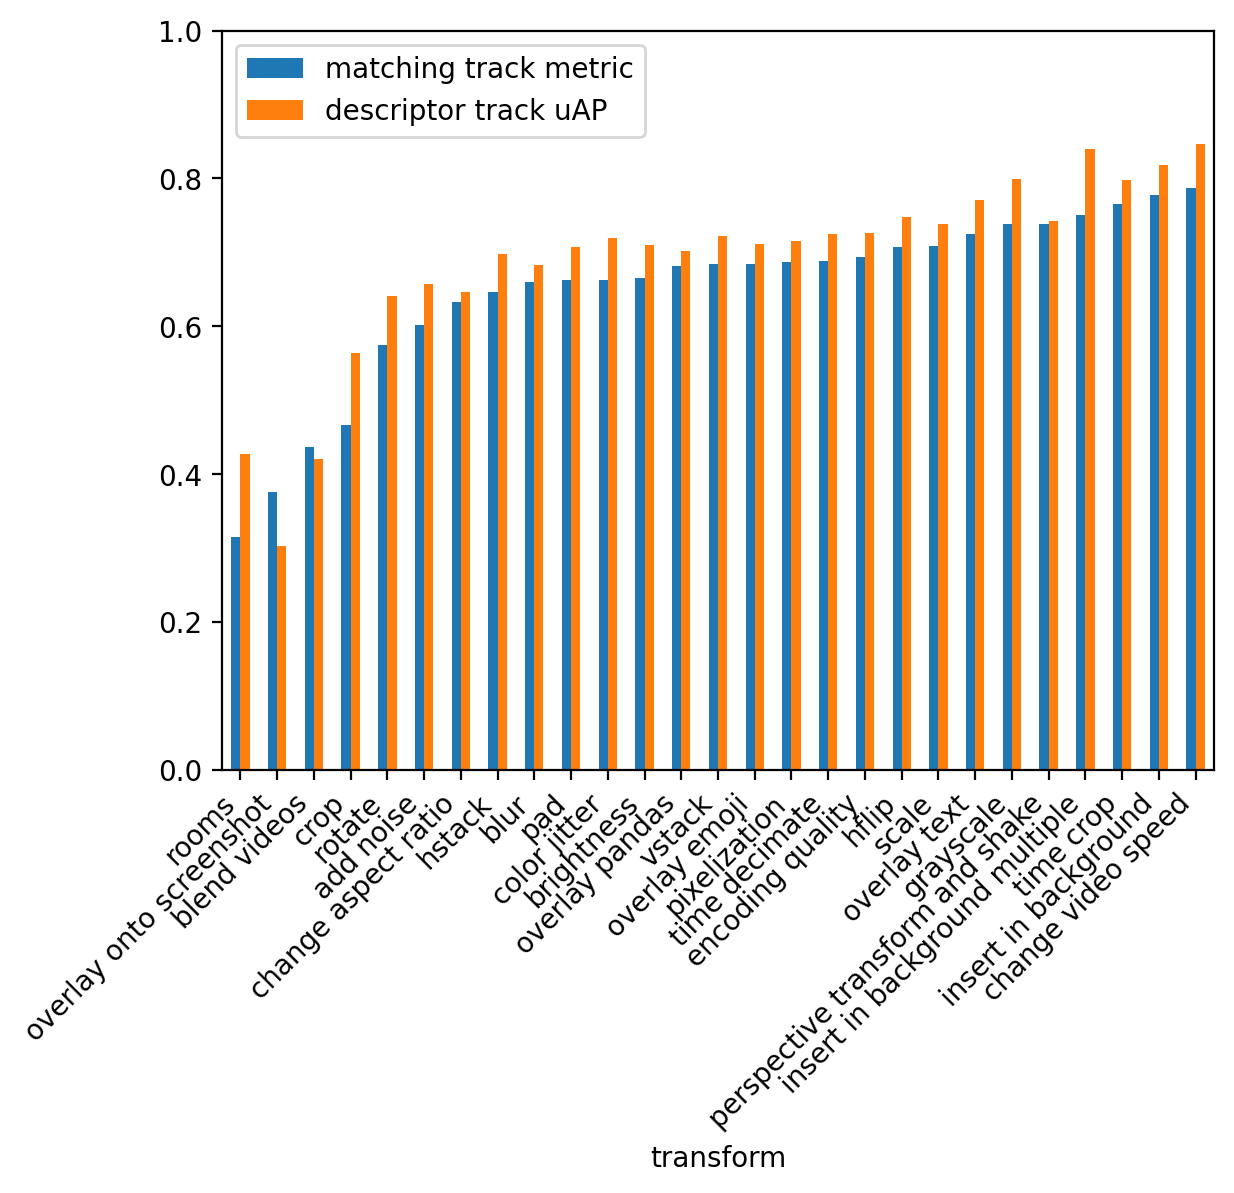

In [105]:
df = adf.copy().set_index("transform")[["matching track metric"]]
df2 = adf_d.copy().set_index("transform")[["descriptor track uAP"]]
by_transform_df = df.join(df2)
ax = by_transform_df.plot.bar()
ax.set_ylim(0, 1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.legend(loc='upper left')
plt.savefig(OUTPUT_PATH + '/transform_metrics.pdf', bbox_inches="tight")
None

In [106]:
by_transform_df.to_csv(OUTPUT_PATH + '/transform_metrics.csv')

In [ ]:
# leave one out
adf_loo = analyze_transforms(all_transforms, exclude=True)

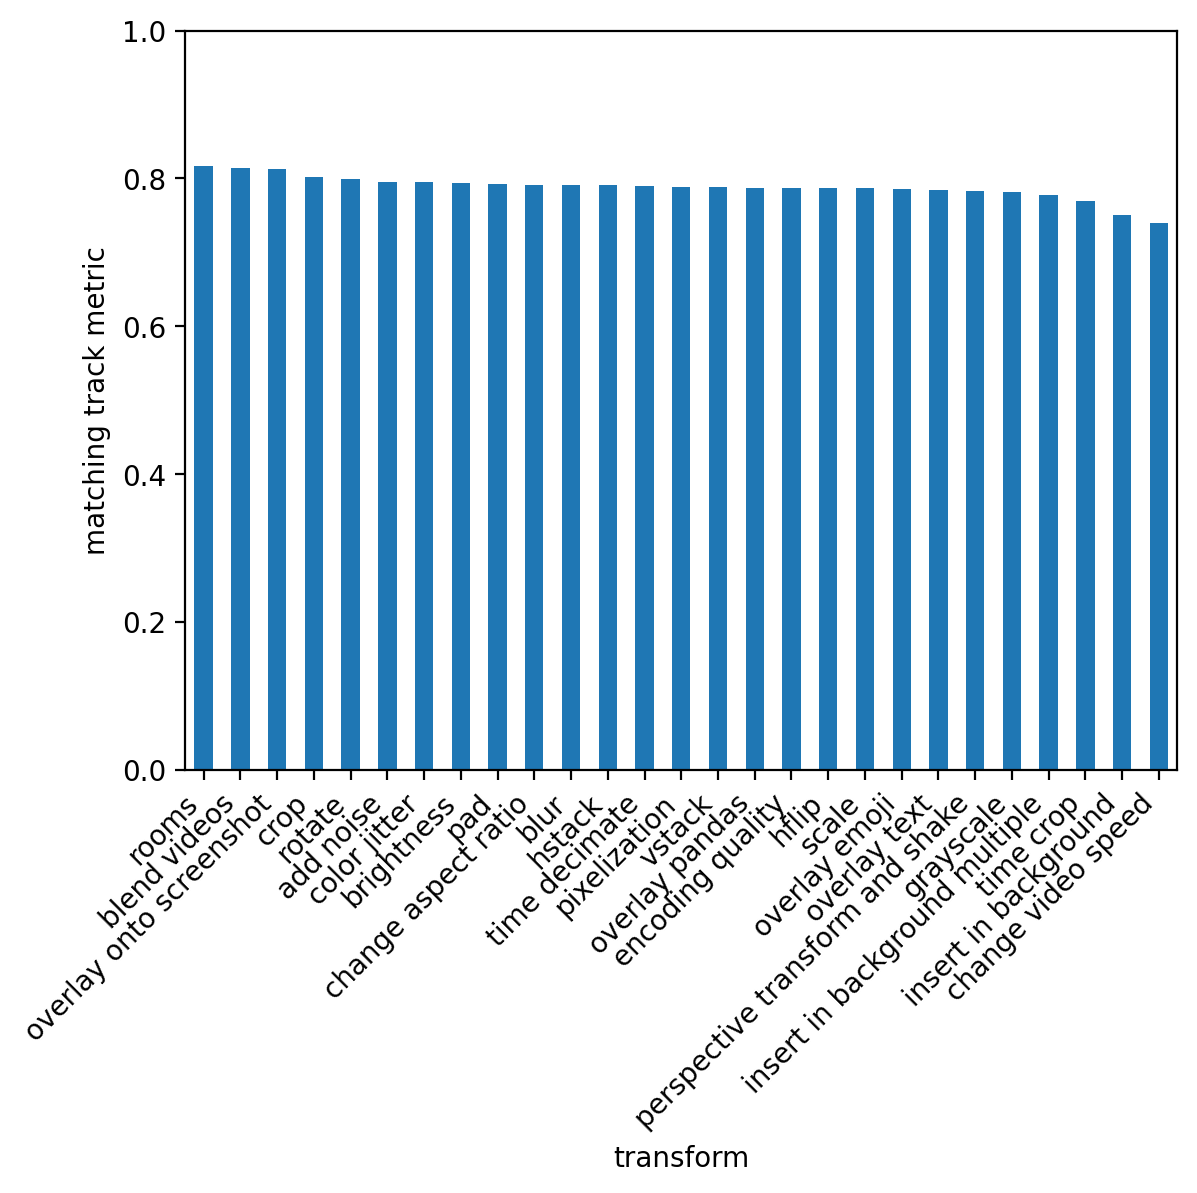

In [243]:
ax = adf_loo.plot.bar(x="transform", y="matching track metric", legend=False)
ax.set_ylim(0, 1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel("matching track metric")
None

In [68]:
def query_ids_by_num_xforms(gt_df):
    df = gt_df.copy()
    df["num_xforms"] = gt_df.transforms.map(len)
    return {
        i: set(df[df.num_xforms == i].query_id.values)
        for i in sorted(set(df.num_xforms.values))
    }


query_ids_by_n_xforms = query_ids_by_num_xforms(gt_df)

In [69]:
by_num_xforms = pd.DataFrame([
    matching_metric_for_queries(query_ids, gt_df, matching, exclude=False, num_transforms=i)
    for (i, query_ids) in query_ids_by_n_xforms.items()
])

In [70]:
by_num_xforms_desc = pd.DataFrame([
    matching_metric_for_queries(query_ids, gt_df, descriptors, exclude=False, num_transforms=i, descriptor=True)
    for (i, query_ids) in query_ids_by_n_xforms.items()
])

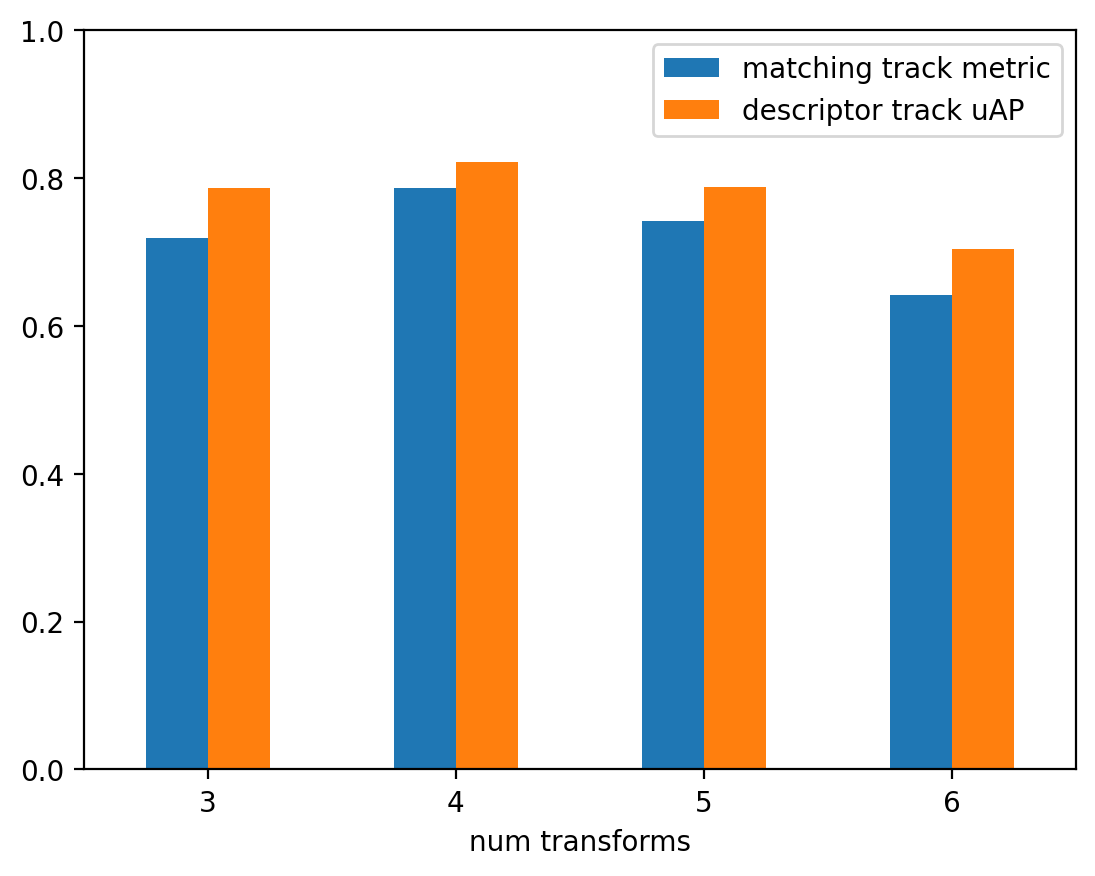

In [82]:
df = by_num_xforms.rename(
    columns=dict(mean_metric="matching track metric", num_transforms="num transforms")
).set_index("num transforms")[["matching track metric"]]
df2 = by_num_xforms_desc.rename(
    columns=dict(mean_metric="descriptor track uAP", num_transforms="num transforms")
).set_index("num transforms")[["descriptor track uAP"]]
by_num_xforms_df = df.join(df2)
ax = by_num_xforms_df.plot.bar()
ax.set_ylim(0, 1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
plt.savefig(OUTPUT_PATH + '/num_transforms_metrics.pdf')
None

In [104]:
by_num_xforms_df.to_csv(OUTPUT_PATH + '/num_transforms_metrics.csv')

Why are 3 xforms harder?

In [94]:
df = gt_df.copy()
df["num_xforms"] = gt_df.transforms.map(len)

In [97]:
df2 = pd.DataFrame(
    collections.Counter(itertools.chain(*df.transforms.values)).items(),
    columns=["transform", "count"],
).sort_values("count", ascending=False).reset_index(drop=True)
df2["fraction"] = df2["count"] / len(df)
df2

,transform,count,fraction
0,insert in background,1766,0.701072
1,change video speed,1516,0.601826
2,time crop,1234,0.489877
3,insert in background multiple,753,0.298928
4,time decimate,532,0.211195
5,grayscale,512,0.203255
6,color jitter,497,0.197301
7,brightness,463,0.183803
8,hflip,332,0.131798
9,pad,318,0.126241


In [99]:
df3 = df[df.num_xforms == 3]
df2 = pd.DataFrame(
    collections.Counter(itertools.chain(*df3.transforms.values)).items(),
    columns=["transform", "count"],
).sort_values("count", ascending=False).reset_index(drop=True)
df2["fraction"] = df2["count"] / len(df3)
df2

,transform,count,fraction
0,insert in background multiple,235,1.000000
1,change video speed,96,0.408511
2,grayscale,33,0.140426
3,crop,26,0.110638
4,hflip,23,0.097872
5,perspective transform and shake,22,0.093617
6,color jitter,22,0.093617
7,brightness,21,0.089362
8,scale,20,0.085106
9,overlay onto screenshot,20,0.085106


In [284]:
set(df[df.num_xforms == 3].transforms.map(lambda x: x[0]).values)

{'insert in background multiple'}

In [289]:
# df[df.num_xforms == 6].transform_name.values

In [87]:
import sklearn.metrics

In [90]:
#sklearn.metrics.average_precision_score(y_true, y_score, *, average='macro', pos_label=1, sample_weight=None)
sklearn.metrics.average_precision_score(
    [1, 0], [2, 1]
)

1.0